In [5]:
import pandas as pd

original_data_path = "../data/SP500_all_time.csv"
df = pd.read_csv(original_data_path)
# turn all columns into lowercase
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df.head()   

date       open       high        low      close  adj close  volume
0 1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1 1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2 1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
3 1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
4 1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0

In [6]:
import plotly.graph_objects as go

# Create a hover text string that includes date and prices for each point
hover_texts = df['date'].dt.strftime('%Y-%m-%d') + '<br>Open: ' + df['open'].astype(str) + '<br>High: ' + df['high'].astype(str) + '<br>Low: ' + df['low'].astype(str) + '<br>Close: ' + df['close'].astype(str)

# Create an interactive candlestick chart using Plotly with custom hover text
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     hovertext=hover_texts,
                                     hoverinfo='text')])  # Use 'text' for custom hovertext


# Find the index positions of the middle of each trading day
middle_indices = df.groupby(df['date'].dt.date).apply(lambda x: x.index[len(x)//2]).values

# Create custom x-axis labels based on the middle index positions
x_labels = df.loc[middle_indices, 'date'].dt.strftime('%m-%d')

# Correctly find the numeric index positions of the first and last entries for each trading day
first_indices = df.groupby(df['date'].dt.date).apply(lambda x: x.index[0]).values
last_indices = df.groupby(df['date'].dt.date).apply(lambda x: x.index[-1]).values


# Create vertical lines for the start and end of each trading day
shapes = [dict(type='line',
               x0=i, y0=df['low'].min(), x1=i, y1=df['high'].max(),
               xref='x', yref='y',
               line=dict(color='green', width=1, dash='dash'))
          for i in first_indices]

# Create a separate trace for the volume data
volume_trace = go.Bar(x=df.index, y=df['volume'], name='Volume', yaxis='y2')

# Add the volume trace to the figure
fig.add_trace(volume_trace)

# Customize the layout
fig.update_layout(
    title='Historical Prices',
    yaxis=dict(title='Price'),
    yaxis2=dict(title='Volume', overlaying='y', side='right'),
    xaxis=dict(
        tickmode='array',
        #tickvals=middle_indices,
        #ticktext=x_labels,
        tickangle=-45
    ),
    xaxis_rangeslider_visible=False,
    #shapes=shapes
)

# Display the interactive plot
fig.show()

In [7]:
# Line plot on the closing prices only
fig = go.Figure(data=go.Scatter(x=df.index, y=df['close'], mode='lines'))
fig.update_layout(title='Closing Prices', xaxis_title='Time', yaxis_title='Price')
fig.show()

In [8]:
df.head()

date       open       high        low      close  adj close  volume
0 1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1 1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2 1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
3 1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
4 1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0

In [9]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import ta

# Assuming your DataFrame is named 'df' and contains 'close', 'volume', 'high', and 'low' columns
df['index'] = df.index.astype(int)
df['log_volume'] = np.log(df['volume'] + 1)
df['pct_change'] = df['close'].pct_change()
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# add indicators
df['sma_10'] = ta.trend.sma_indicator(df['close'], window=10)
df['sma_30'] = ta.trend.sma_indicator(df['close'], window=30)
df['ema_10'] = ta.trend.ema_indicator(df['close'], window=10)
df['ema_30'] = ta.trend.ema_indicator(df['close'], window=30)
df['rsi'] = ta.momentum.rsi(df['close'], window=14)
df['macd'] = ta.trend.macd(df['close'], window_slow=26, window_fast=12)
df['macd_signal'] = ta.trend.macd_signal(df['close'], window_slow=26, window_fast=12)
df['macd_diff'] = ta.trend.macd_diff(df['close'], window_slow=26, window_fast=12)
df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'], window=20, window_dev=2)
df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'], window=20, window_dev=2)
df['stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['stoch_signal'] = ta.momentum.stoch_signal(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], window=14)

# get the target
df['next_close'] = df['close'].shift(-1)
df['next_pct_change'] = df['pct_change'].shift(-1)

# 1_day_decision
df['1_day_decision'] = df['next_close'] > df['close']
# turn the boolean into 1 and 0
df['1_day_decision'] = df['1_day_decision'].astype(int)


#columns_to_ignore = ['index', 'date', 'next_close', 'close', 'open', 'high', 'low', 'average']
columns_to_ignore = ['index', 'date', 'next_close', 'next_pct_change', '1_day_decision']
target_column = '1_day_decision'

# Drop any missing values from the DataFrame
data = df.dropna()

In [10]:
# scroll to the right to see the new columns
pd.set_option('display.max_columns', None)

data.head()

date       open       high        low      close  adj close  volume  \
33 1928-02-17  17.040001  17.040001  17.040001  17.040001  17.040001       0   
34 1928-02-20  16.950001  16.950001  16.950001  16.950001  16.950001       0   
35 1928-02-21  17.110001  17.110001  17.110001  17.110001  17.110001       0   
36 1928-02-23  17.129999  17.129999  17.129999  17.129999  17.129999       0   
37 1928-02-24  17.180000  17.180000  17.180000  17.180000  17.180000       0   

    index  log_volume  pct_change  day  month  year     sma_10     sma_30  \
33     33         0.0   -0.017867   17      2  1928  17.410000  17.471667   
34     34         0.0   -0.005282   20      2  1928  17.365001  17.448000   
35     35         0.0    0.009440   21      2  1928  17.331000  17.435000   
36     36         0.0    0.001169   23      2  1928  17.300000  17.427000   
37     37         0.0    0.002919   24      2  1928  17.269000  17.421333   

       ema_10     ema_30        rsi      macd  macd_signal  macd_diff  \
33  17.382958  17.479757  32.044492 -0.066451    -0.031401  -0.035050   
34  17.304238  17.445579  29.809956 -0.097557    -0.044632  -0.052925   
35  17.268922  17.423929  38.076966 -0.108053    -0.057316  -0.050737   
36  17.243664  17.404966  39.043340 -0.113450    -0.068543  -0.044907   
37  17.232088  17.390452  41.501525 -0.112397    -0.077314  -0.035083   

    bollinger_high  bollinger_low      stoch  stoch_signal        adx  \
33       17.785260      17.213740   0.000000      0.000000   9.348044   
34       17.846046      17.099954   0.000000      0.000000  11.465309   
35       17.842897      17.050104  23.529481      7.843160  12.353951   
36       17.817394      17.017607  26.470372     16.666618  13.051698   
37       17.810303      16.990697  38.333294     29.444382  13.374072   

    next_close  next_pct_change  1_day_decision  
33   16.950001        -0.005282               0  
34   17.110001         0.009440               1  
35   17.129999         0.001169               1  
36   17.180000         0.002919               1  
37   17.110001        -0.004074               0

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare the data for linear regression
# everything except date and next_close
X = data.drop(columns=columns_to_ignore)
print(X.columns)
y = data[target_column]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term to the scaled data
# X_train_scaled = sm.add_constant(X_train_scaled)
# X_test_scaled = sm.add_constant(X_test_scaled)

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'log_volume',
       'pct_change', 'day', 'month', 'year', 'sma_10', 'sma_30', 'ema_10',
       'ema_30', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'bollinger_high',
       'bollinger_low', 'stoch', 'stoch_signal', 'adx'],
      dtype='object')


In [49]:
# Fit the linear regression model on the training data
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())

# Print explained variance on the training data
print("Explained Variance (R-squared) on Training Data:", model.rsquared)

                                 OLS Regression Results                                
Dep. Variable:         1_day_decision   R-squared (uncentered):                   0.089
Model:                            OLS   Adj. R-squared (uncentered):             -0.088
Method:                 Least Squares   F-statistic:                             0.5021
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                       0.991
Time:                        04:44:53   Log-Likelihood:                         -228.72
No. Observations:                 215   AIC:                                      527.4
Df Residuals:                     180   BIC:                                      645.4
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [50]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print explained variance on the test data
print("Explained Variance (R-squared) on Test Data:", model.rsquared)

# Print mean squared error on the test data
mse = np.mean((y_pred - y_test)**2)
print("Mean Squared Error (MSE) on Test Data:", mse)

# Plot the predicted vs. actual values
# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=np.arange(len(y_test)),
    y=y_test,
    mode='lines',
    name='Actual'
)

trace_predicted = go.Scatter(
    x=np.arange(len(y_pred)),
    y=y_pred,
    mode='lines',
    name='Predicted'
)

# Create the layout for the figure
layout = go.Layout(
    title='Predicted vs. Actual Values',
    xaxis=dict(title='Data Points'),
    yaxis=dict(title='Values')
)

# Create the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)

# Display the figure
fig.show()

Explained Variance (R-squared) on Test Data: 0.088947650196888
Mean Squared Error (MSE) on Test Data: 11.714444397930723


In [12]:
# logistic regression
model = sm.Logit(y_train, X_train_scaled).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.690452
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:         1_day_decision   No. Observations:                19306
Model:                          Logit   Df Residuals:                    19284
Method:                           MLE   Df Model:                           21
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                0.002899
Time:                        20:05:36   Log-Likelihood:                -13330.
converged:                       True   LL-Null:                       -13369.
Covariance Type:            nonrobust   LLR p-value:                 2.101e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3799      0.145      2.612      0.009       0.095       0.665
x2             2.1887      2

Average sum of the test data: 0.5436088667909674
Accuracy: 0.47172156619018024
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.88      0.60      2203
           1       0.56      0.13      0.21      2624

    accuracy                           0.47      4827
   macro avg       0.51      0.50      0.41      4827
weighted avg       0.51      0.47      0.39      4827



c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



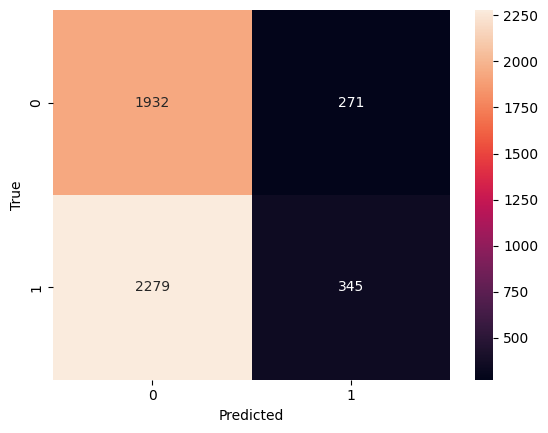

In [14]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the logistic regression model on the training data
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# printthe average sum of the test data
print("Average sum of the test data:", y_test.mean())

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.5046612802983219
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.66      0.55      2203
           1       0.57      0.38      0.45      2624

    accuracy                           0.50      4827
   macro avg       0.52      0.52      0.50      4827
weighted avg       0.52      0.50      0.50      4827



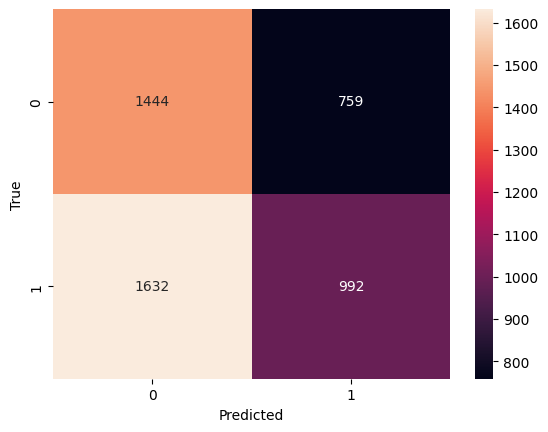

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the decision tree classifier on the training data
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.472757406256474
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.86      0.60      2203
           1       0.56      0.15      0.24      2624

    accuracy                           0.47      4827
   macro avg       0.51      0.50      0.42      4827
weighted avg       0.51      0.47      0.40      4827



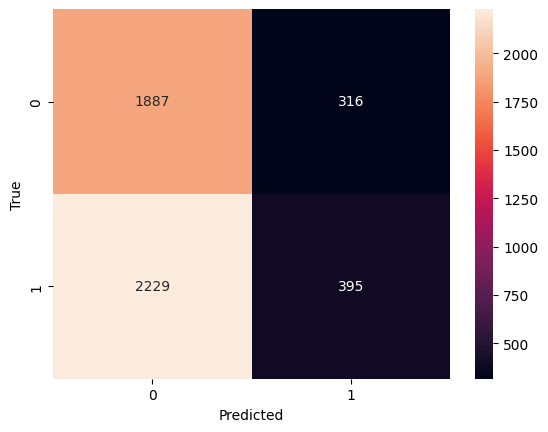

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the random forest classifier on the training data
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.5326289620882536
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.09      0.15      2203
           1       0.54      0.90      0.68      2624

    accuracy                           0.53      4827
   macro avg       0.49      0.50      0.41      4827
weighted avg       0.50      0.53      0.44      4827



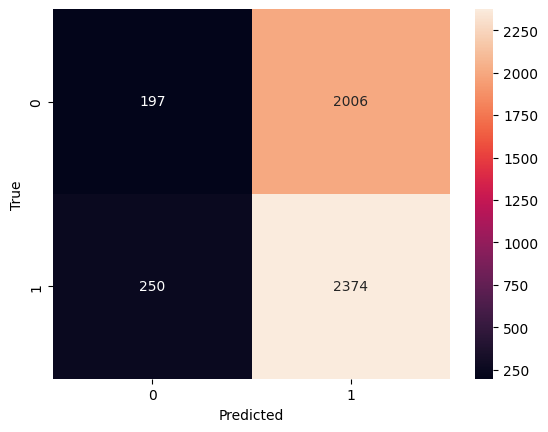

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the SVM classifier on the training data
model = SVC(kernel='rbf', C=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.4563911332090325
Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      2203
           1       0.00      0.00      0.00      2624

    accuracy                           0.46      4827
   macro avg       0.23      0.50      0.31      4827
weighted avg       0.21      0.46      0.29      4827



c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



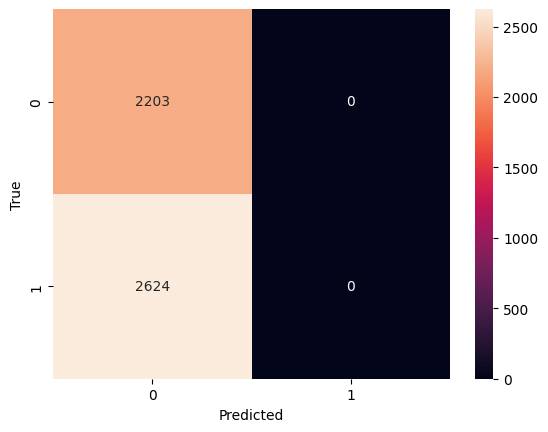

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the Gaussian Naive Bayes classifier on the training data
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.492024031489538
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.59      0.52      2203
           1       0.54      0.41      0.47      2624

    accuracy                           0.49      4827
   macro avg       0.50      0.50      0.49      4827
weighted avg       0.50      0.49      0.49      4827



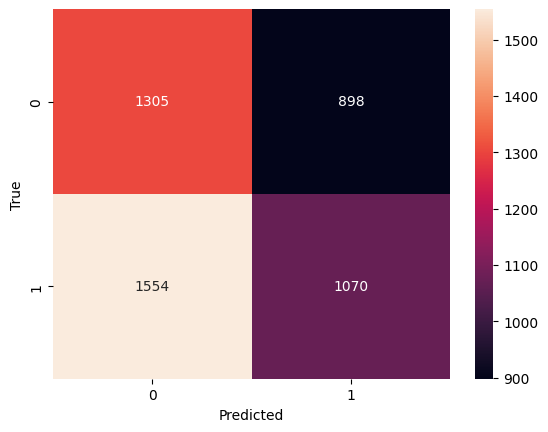

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the KNN classifier on the training data
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.46757820592500515
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.95      0.62      2203
           1       0.60      0.06      0.11      2624

    accuracy                           0.47      4827
   macro avg       0.53      0.51      0.37      4827
weighted avg       0.54      0.47      0.34      4827



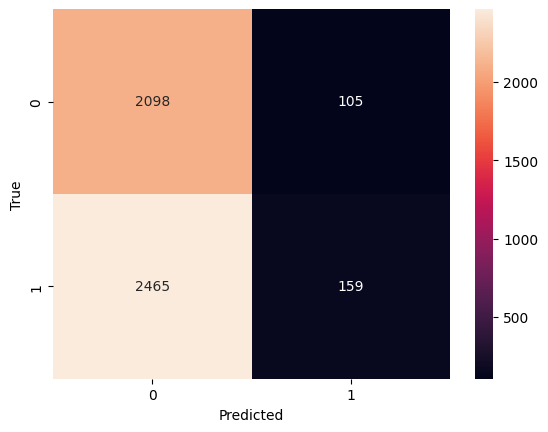

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the Gradient Boosting classifier on the training data
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.45618396519577376
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.98      0.62      2203
           1       0.50      0.02      0.04      2624

    accuracy                           0.46      4827
   macro avg       0.48      0.50      0.33      4827
weighted avg       0.48      0.46      0.30      4827



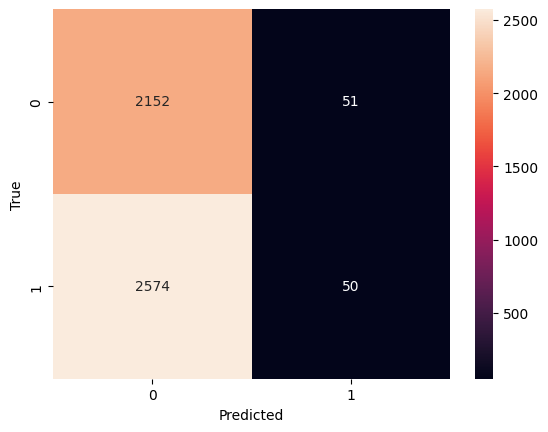

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the AdaBoost classifier on the training data
model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.489538015330433
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.71      0.56      2203
           1       0.56      0.30      0.39      2624

    accuracy                           0.49      4827
   macro avg       0.51      0.51      0.48      4827
weighted avg       0.51      0.49      0.47      4827



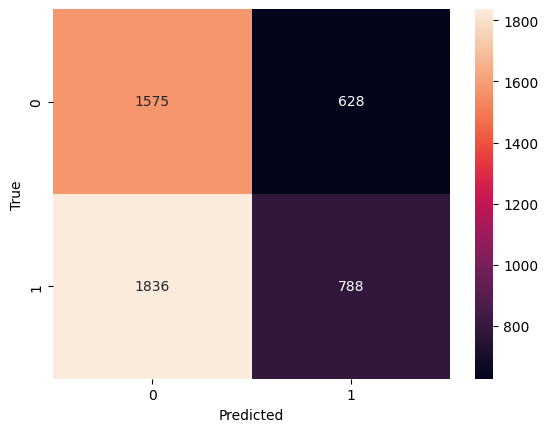

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the MLP classifier on the training data
model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', solver='adam', max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.5003107520198882
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.56      2203
           1       0.57      0.35      0.43      2624

    accuracy                           0.50      4827
   macro avg       0.52      0.52      0.49      4827
weighted avg       0.52      0.50      0.49      4827



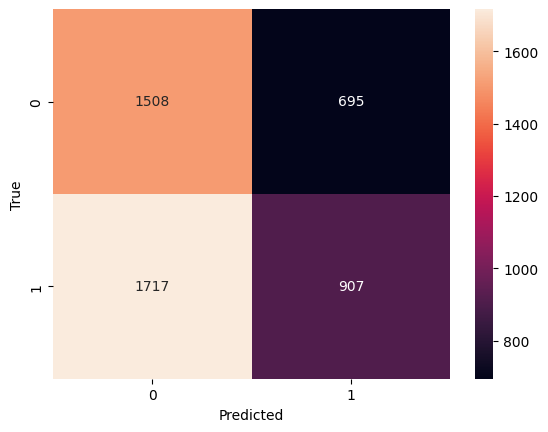

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the XGBoost classifier on the training data
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




Epoch 1/200


449/449 [==============================] - 2s 2ms/step - loss: 0.9502 - accuracy: 0.5194 - val_loss: 0.7059 - val_accuracy: 0.5367
Epoch 2/200
449/449 [==============================] - 1s 1ms/step - loss: 0.6960 - accuracy: 0.5151 - val_loss: 0.6936 - val_accuracy: 0.5296
Epoch 3/200
449/449 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5136 - val_loss: 0.6929 - val_accuracy: 0.5355
Epoch 4/200
449/449 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6912 - val_accuracy: 0.5426
Epoch 5/200
449/449 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5181 - val_loss: 0.6932 - val_accuracy: 0.5178
Epoch 6/200
449/449 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5115 - val_loss: 0.6914 - val_accuracy: 0.5426
Epoch 7/200
449/449 [==============================] - 1s 1ms/step - loss: 0.6929 - accuracy: 0.5206 - val_loss: 0.6915 - val_accuracy: 0

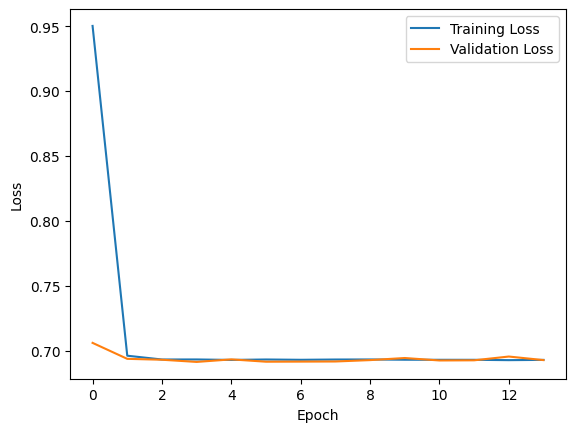

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare the data
features = data.drop(columns=columns_to_ignore).columns
target = target_column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.3, random_state=42, shuffle=False)

# Scale the features using only the training data
scaler_features = StandardScaler()
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

# Build the binary classification model with regularization and dropout
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, verbose=1,
                    validation_split=0.15, callbacks=[early_stopping])

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot the loss and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

227/227 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      3355
           1       0.00      0.00      0.00      3885

    accuracy                           0.46      7240
   macro avg       0.23      0.50      0.32      7240
weighted avg       0.21      0.46      0.29      7240



c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



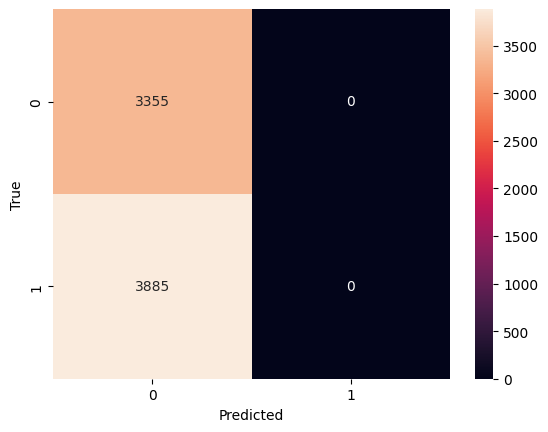

In [25]:
# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch 1/200
528/528 [==============================] - 10s 12ms/step - loss: 0.9889 - accuracy: 0.5148 - val_loss: 0.6928 - val_accuracy: 0.5290
Epoch 2/200
528/528 [==============================] - 4s 8ms/step - loss: 0.6927 - accuracy: 0.5179 - val_loss: 0.6916 - val_accuracy: 0.5290
Epoch 3/200
528/528 [==============================] - 5s 9ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6920 - val_accuracy: 0.5290
Epoch 4/200
528/528 [==============================] - 4s 8ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6917 - val_accuracy: 0.5290
Epoch 5/200
528/528 [==============================] - 4s 7ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6918 - val_accuracy: 0.5290
Epoch 6/200
528/528 [==============================] - 4s 8ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6916 - val_accuracy: 0.5290
Epoch 7/200
528/528 [==============================] - 4s 8ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6916 - val_accuracy: 0.52

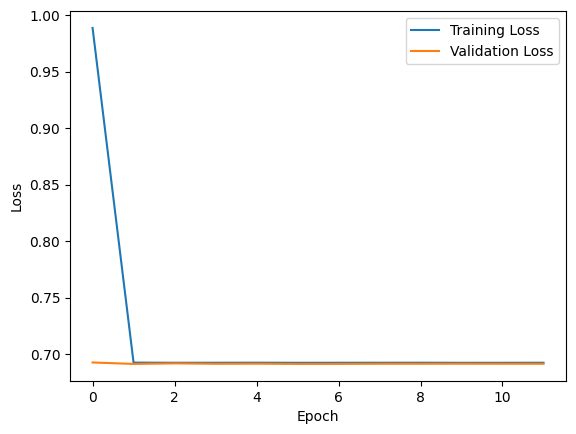

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Prepare the data for LSTM
features = data.drop(columns=columns_to_ignore).columns
target = target_column

# Split the data into training, validation, and testing sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Scale the features using only the training data
scaler_features = StandardScaler()
train_features = scaler_features.fit_transform(train_data[features])
val_features = scaler_features.transform(val_data[features])
test_features = scaler_features.transform(test_data[features])

# Create the input sequences and corresponding labels for the LSTM model
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of previous days to use as input
X_train, y_train = create_sequences(train_features, train_data[target].values, seq_length)
X_val, y_val = create_sequences(val_features, val_data[target].values, seq_length)
X_test, y_test = create_sequences(test_features, test_data[target].values, seq_length)

# Build the LSTM model with regularization and dropout
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot the loss and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1647
           1       0.54      1.00      0.70      1964

    accuracy                           0.54      3611
   macro avg       0.27      0.50      0.35      3611
weighted avg       0.30      0.54      0.38      3611



c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



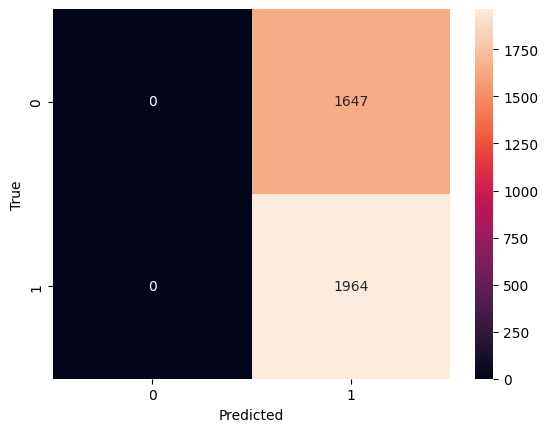

In [27]:
# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




Epoch 1/200

2/2 [==============================] - 4s 802ms/step - loss: 4.3442 - val_loss: 2.0256
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 4.4028 - val_loss: 1.8545
Epoch 3/200
2/2 [==============================] - 0s 45ms/step - loss: 4.0020 - val_loss: 1.8773
Epoch 4/200
2/2 [==============================] - 0s 47ms/step - loss: 4.0503 - val_loss: 1.9696
Epoch 5/200
2/2 [==============================] - 0s 43ms/step - loss: 3.4524 - val_loss: 2.0165
Epoch 6/200
2/2 [==============================] - 0s 40ms/step - loss: 3.4875 - val_loss: 2.0945
Epoch 7/200
2/2 [==============================] - 0s 41ms/step - loss: 3.3705 - val_loss: 2.1882
Epoch 8/200
2/2 [==============================] - 0s 40ms/step - loss: 2.4545 - val_loss: 2.3531
Epoch 9/200
2/2 [==============================] - 0s 37ms/step - loss: 2.6140 - val_loss: 2.5837
Epoch 10/200
2/2 [==============================] - 0s 35ms/step - loss: 3.0869 - val_loss: 2.7404
Epoch 11/200
2

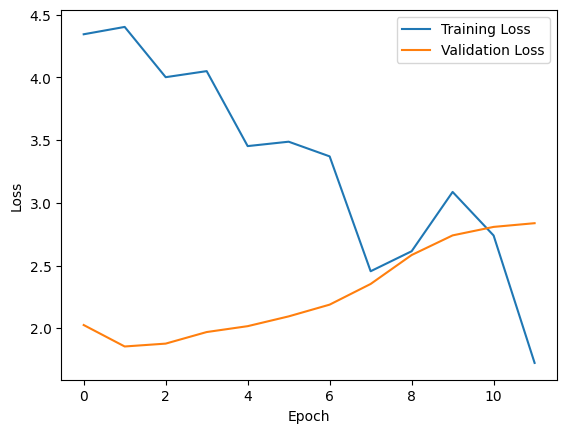

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Prepare the data for LSTM
features = data.drop(columns=columns_to_ignore).columns
target = target_column

# Split the data into training, validation, and testing sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Scale the features and target using only the training data
scaler_features = StandardScaler()
train_features = scaler_features.fit_transform(train_data[features])
val_features = scaler_features.transform(val_data[features])
test_features = scaler_features.transform(test_data[features])

scaler_target = StandardScaler()
train_target = scaler_target.fit_transform(train_data[[target]])
val_target = scaler_target.transform(val_data[[target]])
test_target = scaler_target.transform(test_data[[target]])

# Create the input sequences and corresponding labels for the LSTM model
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of previous days to use as input
X_train, y_train = create_sequences(train_features, train_target, seq_length)
X_val, y_val = create_sequences(val_features, val_target, seq_length)
X_test, y_test = create_sequences(test_features, test_target, seq_length)

# Build the LSTM model with regularization and dropout
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2]),
 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Make predictions on the testing set
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and y_test
predictions = scaler_target.inverse_transform(predictions)
y_test = scaler_target.inverse_transform(y_test)

# Evaluate the model on the scaled values
mse = np.mean((predictions - y_test.reshape(-1, 1))**2)
print("Mean Squared Error (scaled):", mse)

# Plot the loss and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [183]:
# Plot the predicted vs. actual values
trace_actual = go.Scatter(
    x=np.arange(len(y_test)),
    y=y_test.flatten(),
    mode='lines',
    name='Actual'
)
trace_predicted = go.Scatter(
    x=np.arange(len(predictions)),
    y=predictions.flatten(),
    mode='lines',
    name='Predicted'
)

layout = go.Layout(
    title='Predicted vs. Actual Values',
    xaxis=dict(title='Data Points'),
    yaxis=dict(title='Values')
)

fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()